# COVID-19 Severity

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb

In [ ]:
# For reproducibility
np.random.seed(42)

# Load the dataset from an Excel file
data = pd.read_excel('/content/cleaned_updated_final.xlsx')

# Drop rows with missing values
data.dropna(inplace=True)
data.head(5)

,State,District,Date,Cases Daily,Cases Cumulative,Active Daily,Active Cummulative,Recovered Daily,Recovered Cummulative,Deceased Daily,Deceased Cummulative,Tested Daily,Tested Cummulative
0,TG,ADILABAD,2020-01-05 00:00:00,0,0,0,0,0,0,0,0,0,0
1,TG,ADILABAD,2020-02-05 00:00:00,0,0,0,0,0,0,0,0,0,0
2,TG,ADILABAD,2020-03-05 00:00:00,0,0,0,0,0,0,0,0,0,0
3,TG,ADILABAD,2020-04-05 00:00:00,0,0,0,0,0,0,0,0,0,0
4,TG,ADILABAD,2020-05-05 00:00:00,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Remove outliers if necessary
data = data[(data['Cases Cumulative'] < data['Cases Cumulative'].quantile(0.95))]

# Convert categorical columns to numerical if needed (e.g., State, District)
data = pd.get_dummies(data, columns=['State', 'District'])

# Define severity based on the data (example logic)
def define_severity(row):
    if row['Active Cummulative'] > 500:
        return 'Severe'
    elif row['Active Cummulative'] > 100:
        return 'Moderate'
    else:
        return 'Mild'

data['Severity'] = data.apply(define_severity, axis=1)

In [ ]:
# Extract features and target variable
features = data[['Cases Daily', 'Cases Cumulative', 'Active Daily', 'Active Cummulative',
                 'Recovered Daily', 'Recovered Cummulative', 'Deceased Daily', 'Deceased Cummulative',
                 'Tested Daily', 'Tested Cummulative'] + [col for col in data.columns if col.startswith('State_') or col.startswith('District_')]]
target = data['Severity']

# Convert target variable to numeric
target = target.map({'Mild': 0, 'Moderate': 1, 'Severe': 2})


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Check class distribution in the test set
print(f'Class distribution in y_test:\n{pd.Series(y_test).value_counts()}')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Class distribution in y_test:
Severity
0    494
1     23
Name: count, dtype: int64
Accuracy: 0.9961315280464217
Precision: 0.9961315280464217
Recall: 0.9961315280464217
F1 Score: 0.9961315280464217


In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_split=5, n_est

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [ ]:
# Best parameters and model
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Accuracy: 0.9961315280464217


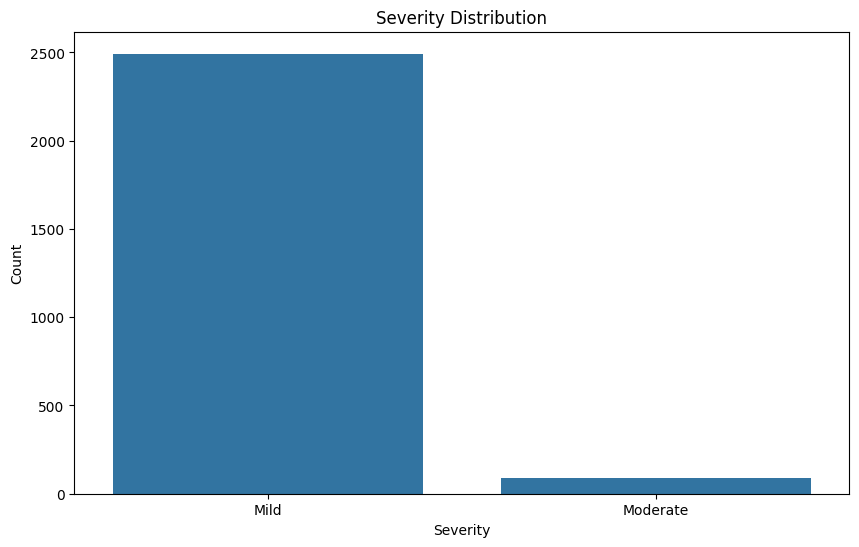

In [ ]:
# 1. Severity Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Severity', data=data)
plt.title('Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

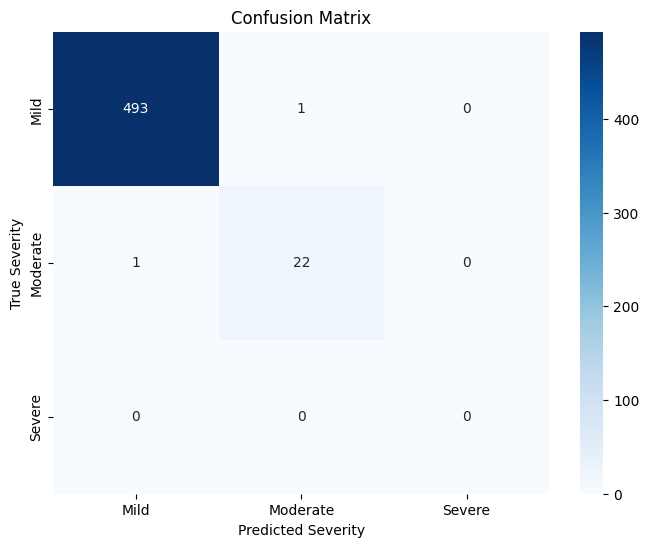

In [ ]:
# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild', 'Moderate', 'Severe'], yticklabels=['Mild', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Severity')
plt.ylabel('True Severity')
plt.show()

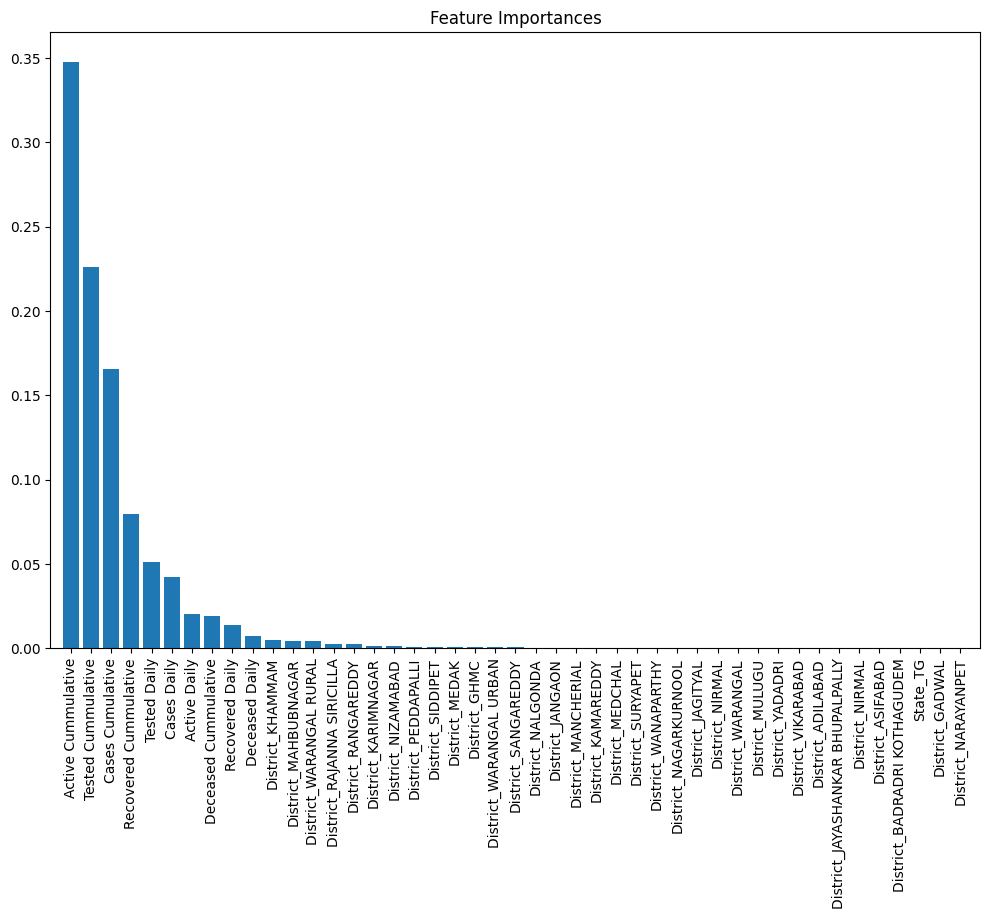

In [ ]:
# 3. Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = features.columns

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), np.array(features_list)[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

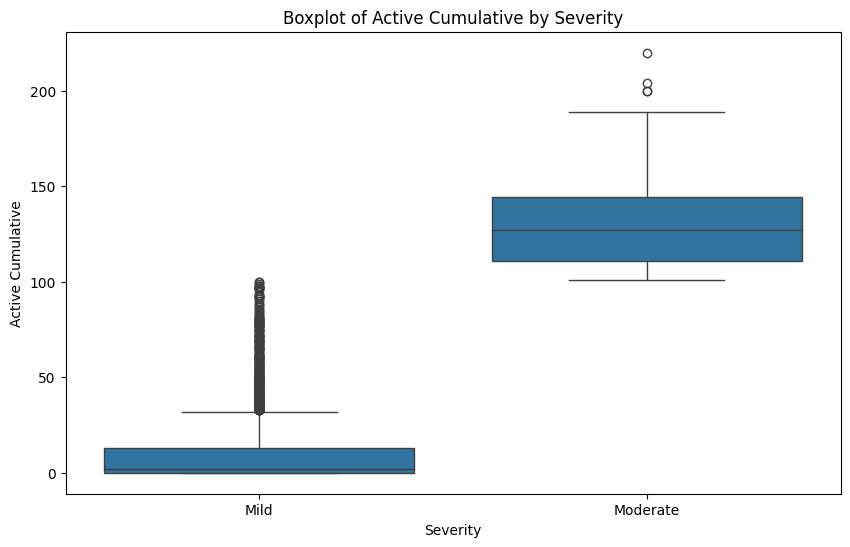

In [ ]:
# 4. Boxplot of 'Active Cummulative' by 'Severity'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity', y='Active Cummulative', data=data)
plt.title('Boxplot of Active Cumulative by Severity')
plt.xlabel('Severity')
plt.ylabel('Active Cumulative')
plt.show()

<Figure size 1200x1000 with 0 Axes>

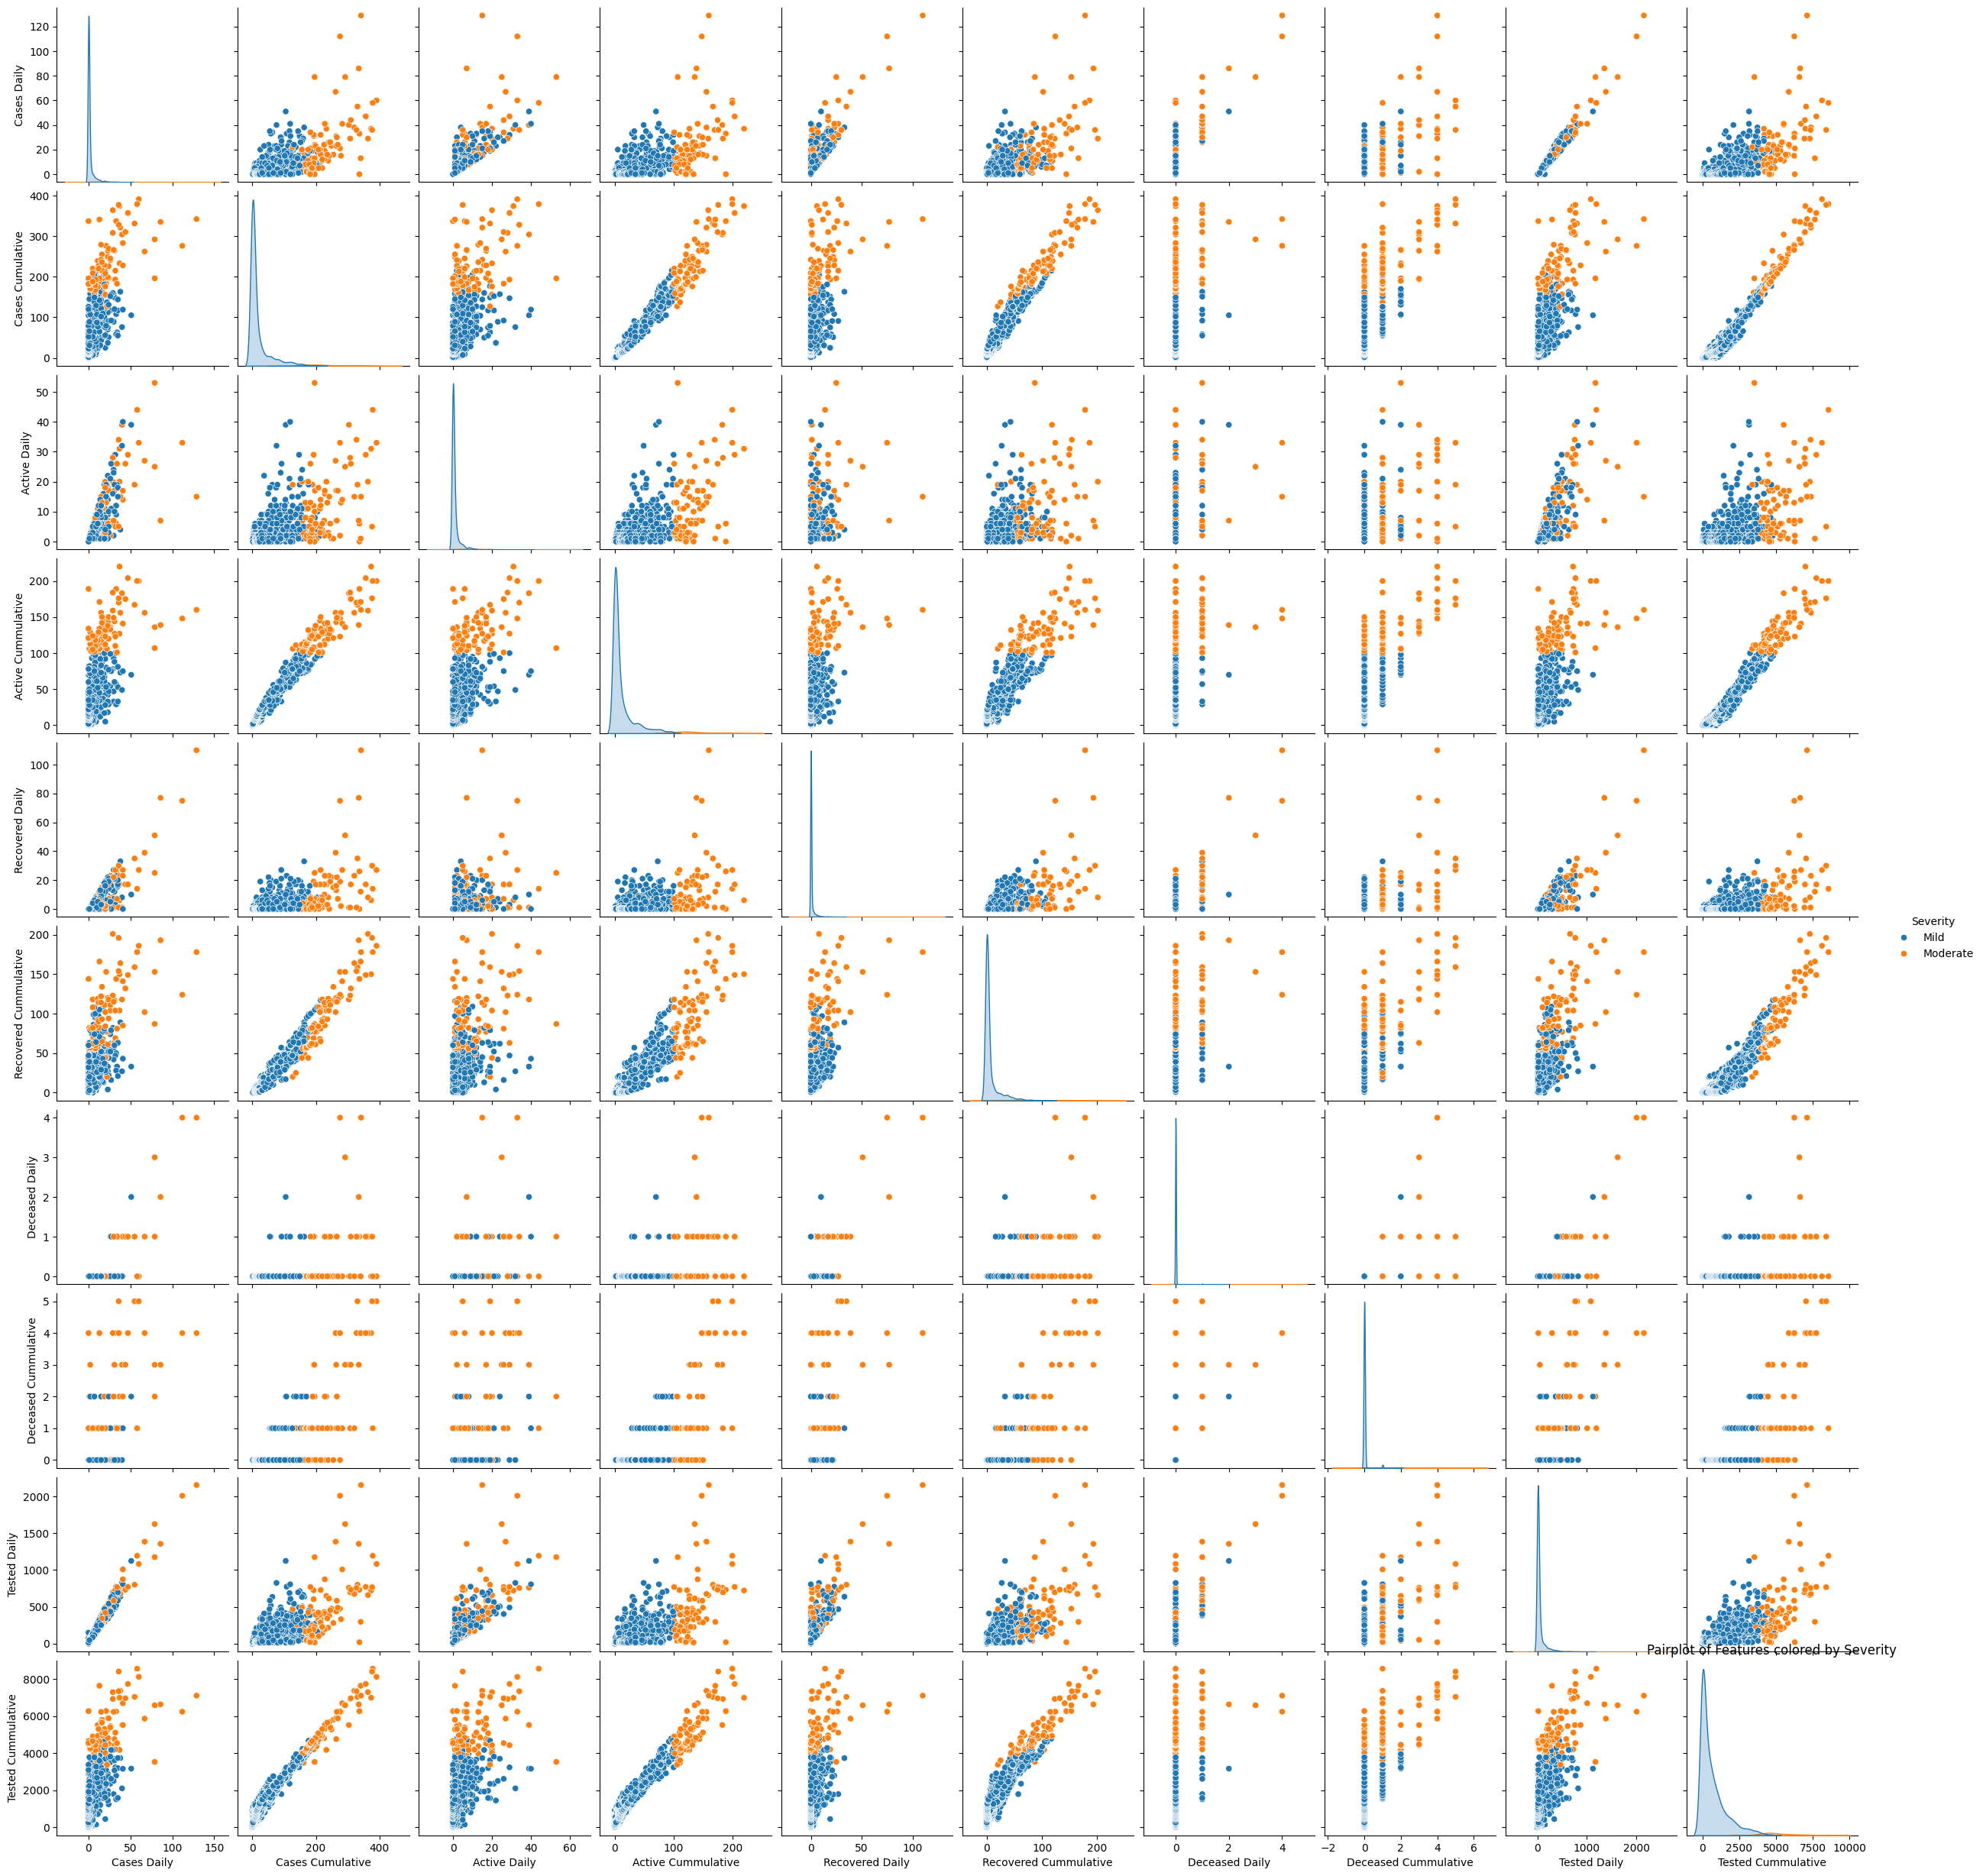

In [ ]:
# 5. Pairplot of Features colored by Severity
plt.figure(figsize=(12, 10))
sns.pairplot(data[['Cases Daily', 'Cases Cumulative', 'Active Daily', 'Active Cummulative', 'Recovered Daily', 'Recovered Cummulative', 'Deceased Daily', 'Deceased Cummulative', 'Tested Daily', 'Tested Cummulative', 'Severity']].dropna(), hue='Severity')
plt.title('Pairplot of Features colored by Severity')
plt.show()

<ipython-input-84-edb849f5a9ab>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='District', y='Active Cummulative', data=top_15_districts, palette='Blues_d')


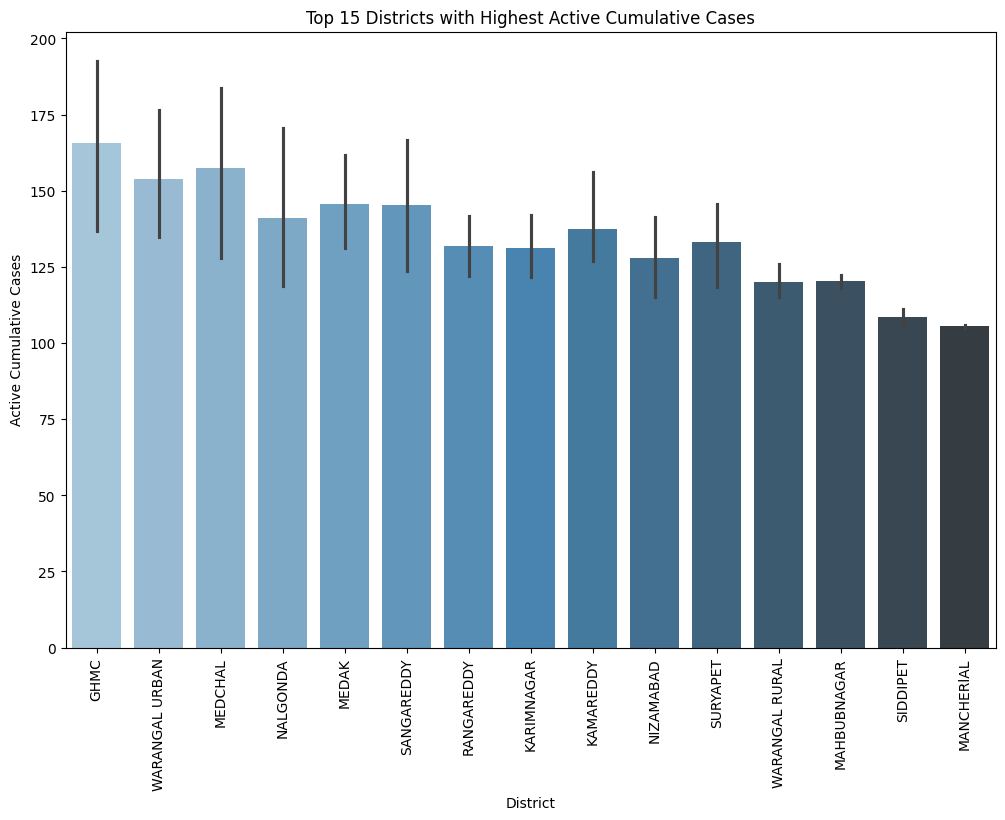

In [ ]:
#6 Get the top 15 districts with the highest 'Active Cummulative' cases
data = pd.read_excel('/content/cleaned_updated_final.xlsx')
data.dropna(inplace=True)
data = data[(data['Cases Cumulative'] < data['Cases Cumulative'].quantile(0.95))]
top_15_districts = data.nlargest(80, 'Active Cummulative')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='District', y='Active Cummulative', data=top_15_districts, palette='Blues_d')
plt.title('Top 15 Districts with Highest Active Cumulative Cases')
plt.xlabel('District')
plt.ylabel('Active Cumulative Cases')
plt.xticks(rotation=90)
plt.show()


<ipython-input-88-7b59a7ce0290>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='District', y='Deceased Cummulative', data=top_districts_deceased, palette='Reds_d')


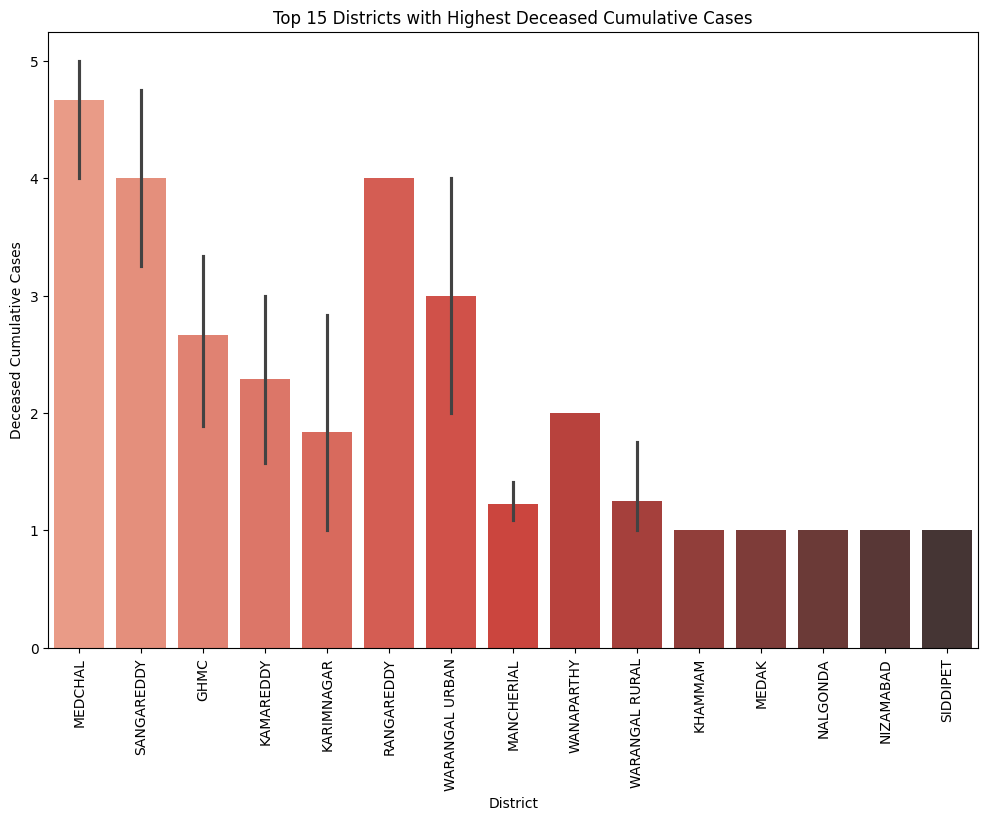

In [ ]:
districts = data['District']
deceased_cumulative = data['Deceased Cummulative']

# Create a DataFrame with the extracted columns
district_data = pd.DataFrame({'District': districts, 'Deceased Cummulative': deceased_cumulative})

# Get the top 10 districts with the highest 'Deceased Cummulative' cases
top_districts_deceased = district_data.nlargest(100, 'Deceased Cummulative')

# Plotting the top districts with the highest 'Deceased Cummulative' cases
plt.figure(figsize=(12, 8))
sns.barplot(x='District', y='Deceased Cummulative', data=top_districts_deceased, palette='Reds_d')
plt.title('Top 15 Districts with Highest Deceased Cumulative Cases')
plt.xlabel('District')
plt.ylabel('Deceased Cumulative Cases')
plt.xticks(rotation=90)
plt.show()